# Regression with a Gaussian Likelihood

## Use necessary packages

In [1]:
using AugmentedGaussianProcesses
const AGP = AugmentedGaussianProcesses
using Distributions
using Plots; pyplot()

Plots.PyPlotBackend()

We create a toy dataset with X ∈ [-20, 20] and y = 5 * sinc(X)

In [2]:
N = 1000
X = reshape((sort(rand(N)) .- 0.5) * 40.0, N, 1)
σ = 0.01

function latent(x)
    5.0 * sinc.(x)
end
Y = vec(latent(X) + σ * randn(N))

1000-element Array{Float64,1}:
 -0.013647427263629499
 -0.02522464730477865
 -0.006097733819367183
 -0.04265185909502786
 -0.0472070022685936
 -0.08389923923038557
 -0.06344795789101988
 -0.07861783652203101
 -0.09345782383299713
 -0.08510143742153307
  ⋮
 -0.057299891369975826
 -0.056787884872071565
 -0.05493063978152045
 -0.0632415614938504
 -0.04088400119765528
 -0.03550436773797571
 -0.026494709510348005
 -0.011358536669455915
 -0.00841747089839347

Visualization of the data :

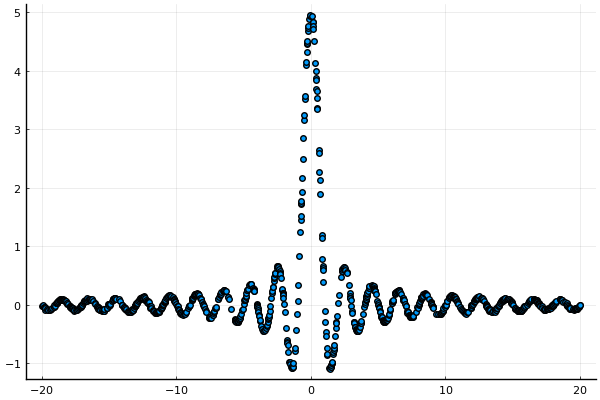

In [3]:
scatter(X, Y, lab="")

## Gaussian noise

In this first example we are going to look at the effect of using
inducing points compared to the true Gaussian Process
For simplicity we will keep all inducing points and kernel parameters fixed

Run sparse classification with an increasing number of inducing points

In [4]:
Ms = [4, 8, 16, 32, 64]

5-element Array{Int64,1}:
  4
  8
 16
 32
 64

Create an empty array of GPs

In [5]:
models = Vector{AbstractGP}(undef,length(Ms) + 1)
kernel = SqExponentialKernel()#  + PeriodicKernel()
for (index, num_inducing) in enumerate(Ms)
    @info "Training with $(num_inducing) points"
    m = SVGP(X, Y, # First arguments are the input and output
            kernel, # Kernel
            GaussianLikelihood(σ), # Likelihood used
            AnalyticVI(), # Inference usede to solve the problem
            num_inducing; # Number of inducing points used
            optimiser = false, # Keep kernel parameters fixed
            Zoptimiser = false, # Keep inducing points locations fixed
    )
    @time train!(m, 100) # Train the model for 100 iterations
    models[index] = m # Save the model in the array
end

┌ Info: Training with 4 points
└ @ Main.##803 string:4
  1.101748 seconds (2.18 M allocations: 137.147 MiB)
┌ Info: Training with 8 points
└ @ Main.##803 string:4
  0.062053 seconds (17.22 k allocations: 60.749 MiB)
┌ Info: Training with 16 points
└ @ Main.##803 string:4
  0.118101 seconds (17.22 k allocations: 111.759 MiB)
┌ Info: Training with 32 points
└ @ Main.##803 string:4
  0.460034 seconds (17.23 k allocations: 218.390 MiB, 48.04% gc time)
┌ Info: Training with 64 points
└ @ Main.##803 string:4
  0.535430 seconds (18.81 k allocations: 450.235 MiB)


Train the model without any inducing points (no approximation)

In [6]:
@info "Training with full model"
mfull = GP(X, Y, kernel,
            noise = σ,
            opt_noise = false, # Keep the noise value fixed
            optimiser = false, # Keep kernel parameters fixed
            )
@time train!(mfull, 5);
models[end] = mfull;

┌ Info: Training with full model
└ @ Main.##803 string:1
  0.738615 seconds (232.94 k allocations: 286.849 MiB)


Create a grid and compute prediction on it

In [7]:
function compute_grid(model, n_grid=50)
    mins = -20; maxs = 20
    x_grid = range(mins, maxs, length = n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, reshape(x_grid, :, 1)) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end

compute_grid (generic function with 2 methods)

Plot the data as a scatter plot

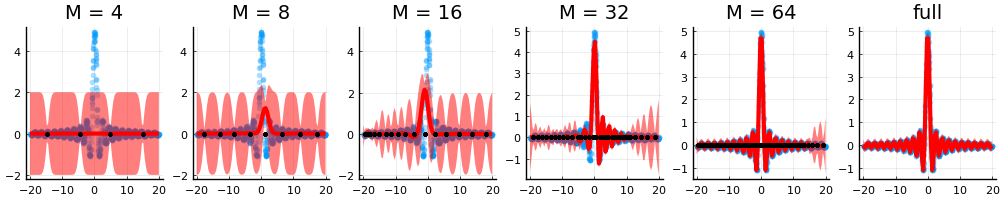

In [8]:
function plotdata(X,Y)
    return Plots.scatter(X, Y, alpha=0.33,
                msw=0.0, lab="", size=(300,500))
end

function plot_model(model, X, Y, title = nothing)
    n_grid = 100
    y_grid, sig_y_grid, x_grid = compute_grid(model,n_grid)
    title = if isnothing(title)
        (model isa SVGP ? "M = $(dim(model[1]))" : "full")
    else
        title
    end

    p = plotdata(X, Y)
    Plots.plot!(p, x_grid, y_grid,
                ribbon=2 * sqrt.(sig_y_grid), # Plot 2 std deviations
                title=title,
                color="red",
                lab="",
                linewidth=3.0)
    if model isa SVGP # Plot the inducing points as well
        Plots.plot!(p,
                    vec(model.f[1].Z),
                    zeros(dim(model.f[1])),
                    msize=2.0,
                    color="black",t=:scatter,lab="")
    end
    return p
end;

Plots.plot(plot_model.(models, Ref(X), Ref(Y))...,
            layout=(1, length(models)),
            size=(1000,200)
        ) # Plot all models and combine the plots

## Non-Gaussian Likelihoods
We now look at using another noise than Gaussian noise.
In AGP.jl you can use the Student-T likelihood,
the Laplace likelihood and the Heteroscedastic likelihood

We will use the same toy dataset for our experiment

Create an array of model with different likelihoods:

In [9]:
likelihoods = [StudentTLikelihood(3.0),
                LaplaceLikelihood(3.0),
                HeteroscedasticLikelihood(1.0)]
ngmodels = Vector{AbstractGP}(undef, length(likelihoods)+1)
for (i, l) in enumerate(likelihoods)
    @info "Training with the $(l)" # We need to use VGP
    m = VGP(X, Y, # First arguments are the input and output
            kernel, # Kernel
            l, # Likelihood used
            AnalyticVI(), # Inference usede to solve the problem
            optimiser = false, # Keep kernel parameters fixed
    )
    @time train!(m, 10) # Train the model for 100 iterations
    ngmodels[i] = m # Save the model in the array
end

ngmodels[end] = models[end] # Add the Gaussian model

┌ Info: Training with the Student-t likelihood
└ @ Main.##803 string:6
  2.086028 seconds (567.02 k allocations: 886.938 MiB, 4.54% gc time)
┌ Info: Training with the Laplace likelihood
└ @ Main.##803 string:6
  1.756621 seconds (44.60 k allocations: 862.269 MiB)
┌ Info: Training with the Gaussian likelihood with heteroscedastic noise
└ @ Main.##803 string:6
  3.593426 seconds (394.19 k allocations: 1.742 GiB, 1.41% gc time)


Gaussian Process with a Gaussian likelihood (σ² = 0.01) infered by Analytic Inference 

We can now repeat the prediction from before :

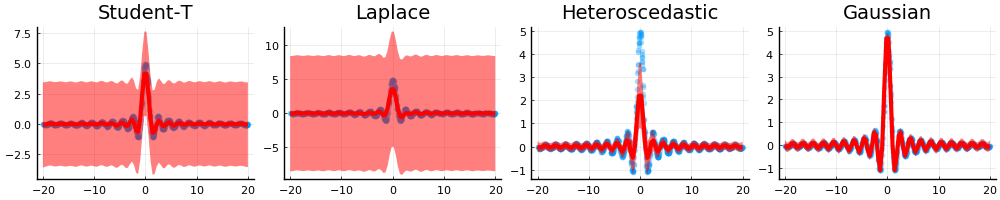

In [10]:
Plots.plot(plot_model.(ngmodels, Ref(X), Ref(Y), ["Student-T", "Laplace", "Heteroscedastic", "Gaussian"])...,
            layout=(1, length(ngmodels)),
            size=(1000,200)
        ) # Plot all models and combine the plots

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*